# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

# Специальные служебные токены
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # служебный токен начала строки
        tokenized_sentence = [self.bos_id]
        # суммируем позиции слов
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        # добавляем айди токена конца строки
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

# последовательности разных длин в один батч
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        # тензор токенов
        'input_ids': sequences,
        # тензор меток класса
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Испытание 1: различные способы агрегации

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        #max_pulling
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [ ]:
def train(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch):
  eval_steps = len(train_dataloader) // 2

  losses_type = {}
  acc_type = {}

  for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    model.aggregation_type = aggregation_type

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

  plt.title('Losses')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

  plt.title('Accuracy')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

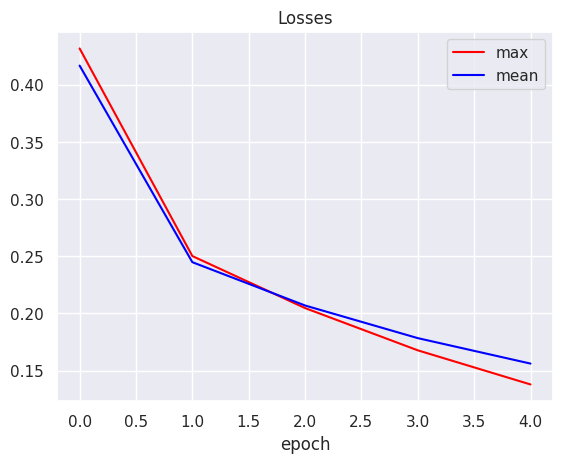

Лучшая accuracy для подхода max: 90.90
Лучшая accuracy для подхода mean: 90.85


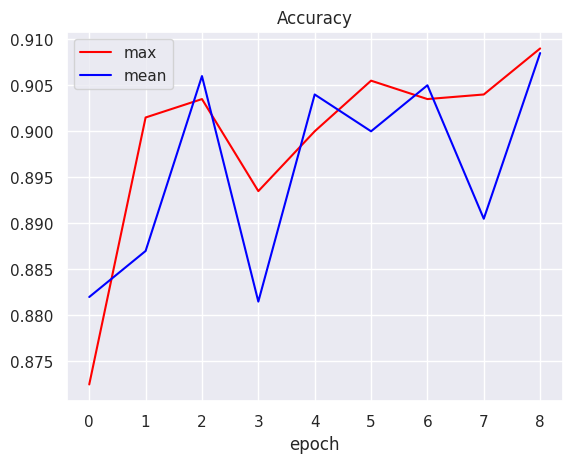

In [ ]:
train(model, criterion, optimizer, train_dataloader, eval_dataloader, 5)

#Эксперимент с моделью RNN. Тестирование с GRU.

In [ ]:
class modelGRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', gru_num_layers: int = 1, gru_dropout: int = 0,
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        #max_pulling
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = modelGRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

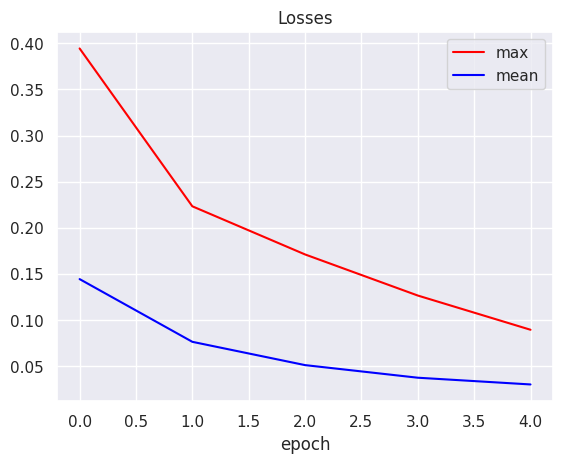

Лучшая accuracy для подхода max: 91.40
Лучшая accuracy для подхода mean: 90.70


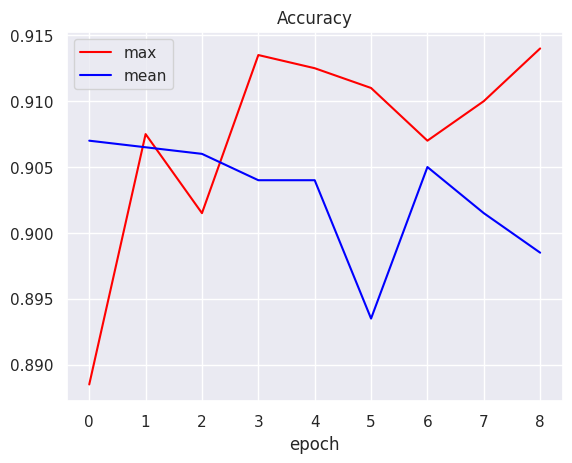

In [ ]:
train(model, criterion, optimizer, train_dataloader, eval_dataloader, 5)

#Увеличение количества рекуррентных слоев модели

Количество слоев в RNN: 2
Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2475, device='cuda:0')
tensor(0.8930, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9040, device='cuda:0')
tensor(0.9040, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9025, device='cuda:0')
tensor(0.9060, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.8980, device='cuda:0')
tensor(0.9075, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9120, device='cuda:0')
tensor(0.9000, device='cuda:0')
Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2570, device='cuda:0')
tensor(0.8760, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.8965, device='cuda:0')
tensor(0.8995, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9045, device='cuda:0')
tensor(0.9055, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9085, device='cuda:0')
tensor(0.9055, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9005, device='cuda:0')
tensor(0.9115, device='cuda:0')
Лучшая accuracy для подхода max: 91.20
Лучшая accuracy для подхода mean: 91.15


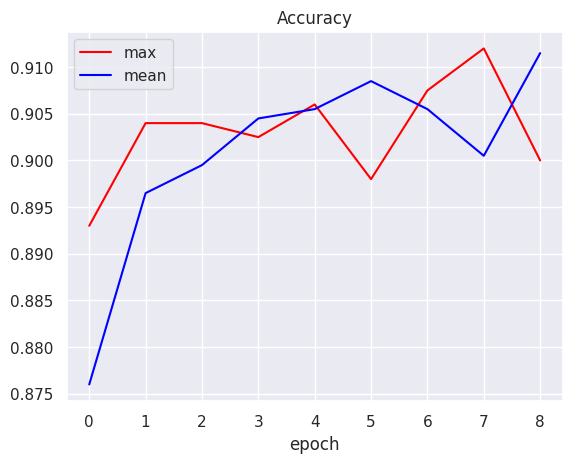





Количество слоев в RNN: 3
Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2550, device='cuda:0')
tensor(0.8950, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9105, device='cuda:0')
tensor(0.8935, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9120, device='cuda:0')
tensor(0.9090, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9125, device='cuda:0')
tensor(0.9065, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9110, device='cuda:0')
tensor(0.9020, device='cuda:0')
Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2560, device='cuda:0')
tensor(0.8760, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.8985, device='cuda:0')
tensor(0.8925, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9125, device='cuda:0')
tensor(0.9105, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9015, device='cuda:0')
tensor(0.9050, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9025, device='cuda:0')
tensor(0.9020, device='cuda:0')
Лучшая accuracy для подхода max: 91.25
Лучшая accuracy для подхода mean: 91.25


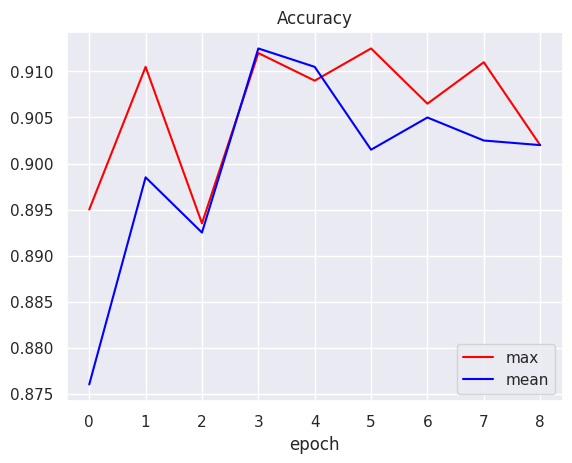





Количество слоев в RNN: 4
Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2620, device='cuda:0')
tensor(0.8850, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.8970, device='cuda:0')
tensor(0.9055, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9105, device='cuda:0')
tensor(0.9160, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9095, device='cuda:0')
tensor(0.9095, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9050, device='cuda:0')
tensor(0.9075, device='cuda:0')
Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2545, device='cuda:0')
tensor(0.8800, device='cuda:0')


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.8930, device='cuda:0')
tensor(0.8980, device='cuda:0')


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9115, device='cuda:0')
tensor(0.9050, device='cuda:0')


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9140, device='cuda:0')
tensor(0.9115, device='cuda:0')


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.9105, device='cuda:0')
tensor(0.9115, device='cuda:0')
Лучшая accuracy для подхода max: 91.60
Лучшая accuracy для подхода mean: 91.40


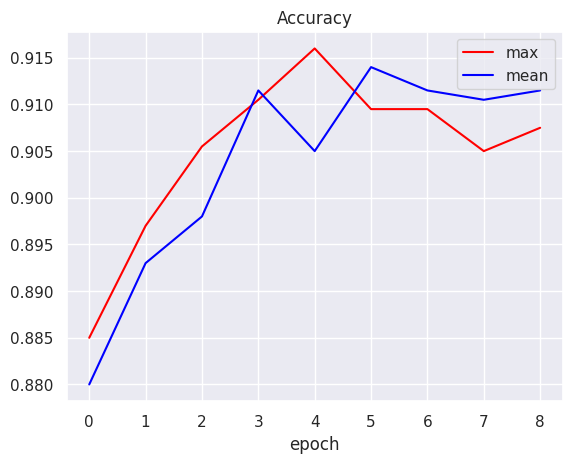

In [ ]:
num_layers = [2, 3, 4]
for num in num_layers:
    print(f"Количество слоев в RNN: {num}")
    model = modelGRU(hidden_dim=256, vocab_size=len(vocab), gru_num_layers = num).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train(model, criterion, optimizer, train_dataloader, eval_dataloader, 5)

#Испытание: Подбор гиперпараметров и обучение до сходимости.

Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

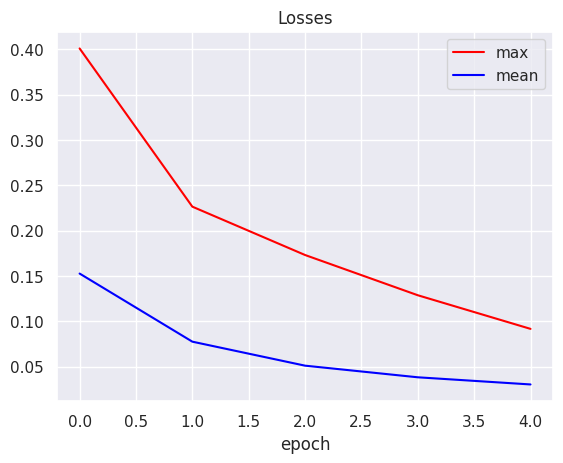

Лучшая accuracy для подхода max: 91.15
Лучшая accuracy для подхода mean: 92.00


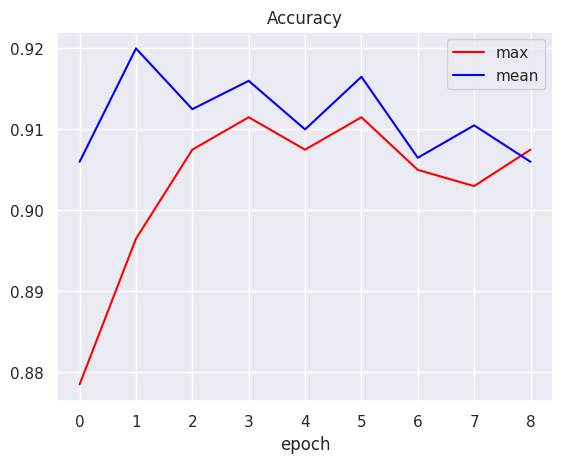

Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

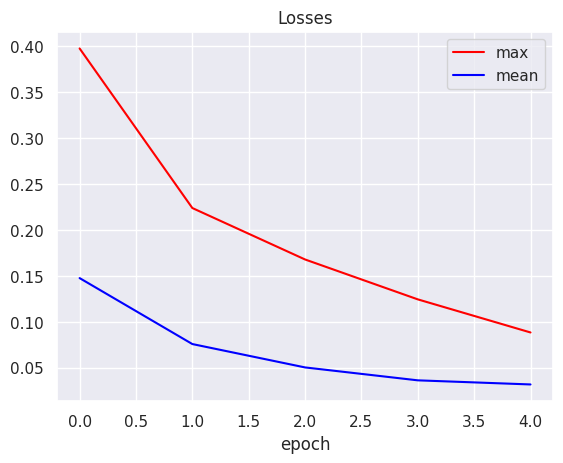

Лучшая accuracy для подхода max: 91.05
Лучшая accuracy для подхода mean: 90.80


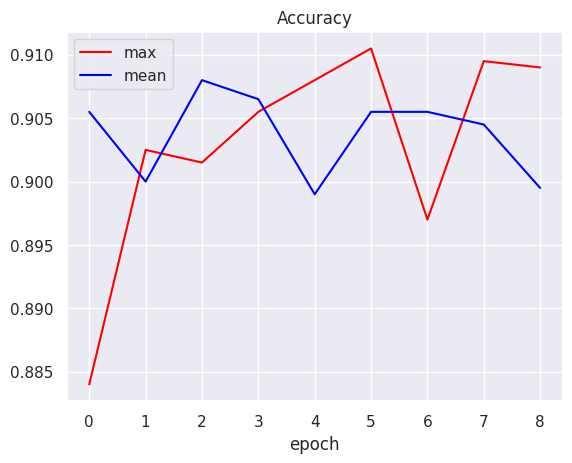

Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
dropouts = [0.2, 0.3, 0.5]
max_epoch = 10
for dropout in dropouts:
    model = modelGRU(hidden_dim=256, vocab_size=len(vocab), gru_num_layers=4, gru_dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train(model, criterion, optimizer, train_dataloader, eval_dataloader, 5)


#Отчет о проделанных испытаниях:

##1. Различные способы агрегации
Были протестированы следующие способы агрегации, получились такие точности:
- max: 90.9
- mean: 90.85

Ответ: max показала себя лучше

##2. Модель GRU c различными способами агрегации
Accuracy:
- max: 91.40
- mean: 90.70

GRU показала выше качество на всех способах агрегации.

##3. Увеличение количества рекуррентных слоев модели GRU
Число слоев варьировалось в диапазоне от 2 до 4.

Переобучение происходит после 2 эпох.

Лучше всего модель себя показала с 4 слоями, вот результаты:

- 2 слоя:
-- Лучшая accuracy для подхода max: 91.20
-- Лучшая accuracy для подхода mean: 91.15
- 3 слоя:
-- Лучшая accuracy для подхода max: 91.25
-- Лучшая accuracy для подхода mean: 91.25
- 4 слоя:
-- Лучшая accuracy для подхода max: 91.60
-- Лучшая accuracy для подхода mean: 91.40

##4. Модель с 2 слоями в GRU блоке и дропаутом

Значение дропаута варьировалось в диапазоне от 0.2 до 0.5.

Переобучение происходит раньше или позже в зависимости от значения дропаута. Наблюдается незначительное изменение в точности модели.

Результаты эксперимента:

- Dropout 0.2, 2 слоя: 92
- Dropout 0.3, 2 слоя: 91.05

# Вывод:
Лучший результат был получен на 4 испытании(модель GRU с 2 слоями, способом агрегации max, точностью 92).